In [1]:
index = 2259
MODIS_path = r"D:\Code\modis-s1-s2\dataset\SatelliteImages\test\MODIS\MODIS_" + str(index) + ".npy"
S1_path = r"D:\Code\modis-s1-s2\dataset\SatelliteImages\test\S1\S1_" + str(index) + ".npy"
ref_path = r"D:\Code\modis-s1-s2\dataset\SatelliteImages\test\ref\ref_" + str(index) + ".npy"
before_path = r"D:\Code\modis-s1-s2\dataset\SatelliteImages\test\before\before_" + str(index) + ".npy"
after_path = r"D:\Code\modis-s1-s2\dataset\SatelliteImages\test\after\after_" + str(index) + ".npy"
g_S2_path = r"D:\Code\modis-s1-s2\output\generated_image\g_S2_" + str(index) + ".npy"
real_S2_path = r"D:\Code\modis-s1-s2\output\generated_image\real_S2_" + str(index) + ".npy"
g_S2_tif_path = r"D:\Code\modis-s1-s2\output\generated_image\g_S2_" + str(index) + ".tif"
real_S2_tif_path = r"D:\Code\modis-s1-s2\output\generated_image\real_S2_" + str(index) + ".tif"
tif_path = r"D:\ENVI\data\NingBo\NB_roi\cropped_data\test\S2\S2_" + str(index) + ".tif"
model_path = r"D:\Code\modis-s1-s2\model\wgan-2\wgan_generator_epoch_300.pth"

print(MODIS_path)
print(S1_path)
print(ref_path)
print(before_path)
print(after_path)
print(g_S2_path)
print(g_S2_tif_path)
print(real_S2_tif_path)
print(tif_path)
print(model_path)

D:\Code\modis-s1-s2\dataset\SatelliteImages\test\MODIS\MODIS_2259.npy
D:\Code\modis-s1-s2\dataset\SatelliteImages\test\S1\S1_2259.npy
D:\Code\modis-s1-s2\dataset\SatelliteImages\test\ref\ref_2259.npy
D:\Code\modis-s1-s2\dataset\SatelliteImages\test\before\before_2259.npy
D:\Code\modis-s1-s2\dataset\SatelliteImages\test\after\after_2259.npy
D:\Code\modis-s1-s2\output\generated_image\g_S2_2259.npy
D:\Code\modis-s1-s2\output\generated_image\g_S2_2259.tif
D:\Code\modis-s1-s2\output\generated_image\real_S2_2259.tif
D:\ENVI\data\NingBo\NB_roi\cropped_data\test\S2\S2_2259.tif
D:\Code\modis-s1-s2\model\wgan-2\wgan_generator_epoch_300.pth


In [3]:
import torch
import numpy as np
import sys
sys.path.append(r"C:\Users\Administrator\Desktop\kaggle\src-2")
from model import Generator

def generate_image(generator, MODIS, S1, ref, before, after, save_path=None):
    MODIS = 2 * MODIS - 1
    S1 = 2 * S1 - 1    # (0, 1) -> (-1, 1)
    ref = 2 * ref - 1
    before = 2 * before - 1
    after = 2 * after - 1
    generator.eval()
    with torch.no_grad():
        g_S2 = generator(MODIS, S1, before, after).cpu().numpy()
        # g_S2 = generator(MODIS, S1, ref).cpu().numpy()
    g_S2 = np.squeeze(g_S2)
    g_S2 = (g_S2 + 1) / 2
    g_S2 = (10000 - 0) * g_S2 + 0
    g_S2 = np.clip(g_S2, 0, 10000)

    if save_path is not None:
        np.save(save_path, g_S2)
    return g_S2

MODIS_input = torch.from_numpy(np.reshape(np.load(MODIS_path).astype('float32'), (-1, 6, 5, 5))).cuda()
S1_input = torch.from_numpy(np.reshape(np.load(S1_path).astype('float32'), (-1, 2, 250, 250))).cuda()
ref_input = torch.from_numpy(np.reshape(np.load(ref_path).astype('float32'), (-1, 8, 250, 250))).cuda()
before_input = torch.from_numpy(np.reshape(np.load(before_path).astype('float32'), (-1, 8, 250, 250))).cuda()
after_input = torch.from_numpy(np.reshape(np.load(after_path).astype('float32'), (-1, 8, 250, 250))).cuda()
generator = torch.load(model_path)
g_S2 = generate_image(generator, MODIS_input, S1_input, ref_input, before_input, after_input, g_S2_path)

print(g_S2.shape)

(8, 250, 250)


In [3]:
import numpy as np

real_s2 = np.load(r"D:\Code\modis-s1-s2\dataset\SatelliteImages\test\S2\S2_" + str(index) + ".npy")
real_s2 = (10000 - 0) * real_s2 + 0
real_s2 = np.clip(real_s2, 0, 10000)

np.save(real_S2_path, real_s2)

In [2]:
from osgeo import gdal
import numpy as np

def save_numpy_as_geotiff(numpy_path, reference_tif_path, output_tif_path):
    numpy_array = np.load(numpy_path)

    # 读取参考tif文件获取地理信息
    reference_dataset = gdal.Open(reference_tif_path)
    reference_geotransform = reference_dataset.GetGeoTransform()
    reference_projection = reference_dataset.GetProjection()

    # 创建输出GeoTIFF文件
    driver = gdal.GetDriverByName("GTiff")
    num_bands, rows, cols = numpy_array.shape
    output_dataset = driver.Create(output_tif_path, cols, rows, num_bands, gdal.GDT_Int16)

    # 设置地理信息
    output_dataset.SetGeoTransform(reference_geotransform)
    output_dataset.SetProjection(reference_projection)

    # 写入数据
    for band_num in range(num_bands):
        output_band = output_dataset.GetRasterBand(band_num + 1)
        output_band.WriteArray(numpy_array[band_num, :, :])

    # 关闭数据集
    output_dataset = None
    reference_dataset = None

save_numpy_as_geotiff(g_S2_path, tif_path, g_S2_tif_path)
save_numpy_as_geotiff(real_S2_path, tif_path, real_S2_tif_path)

In [6]:
import numpy as np

g_s2_1 = np.load(r"D:\Code\modis-s1-s2\output\generated_image\g_S2_2222_1.npy")
g_s2_2 = np.load(r"D:\Code\modis-s1-s2\output\generated_image\g_S2_2222_2.npy")
real_s2 = np.load(r"D:\Code\modis-s1-s2\output\generated_image\real_S2_2222.npy")

l1_1 = np.abs(real_s2-g_s2_1).mean()
l1_2 = np.abs(real_s2-g_s2_2).mean()

print(l1_1, l1_2)

199.89604 175.99655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


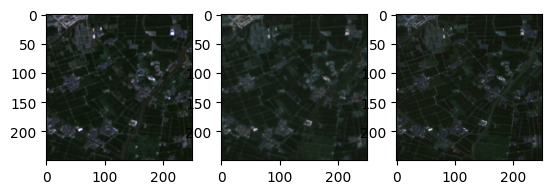

In [3]:
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow((g_s2_1/5000)[:3].transpose((1, 2, 0)))
plt.subplot(1, 3, 2)
plt.imshow((g_s2_2/5000)[:3].transpose((1, 2, 0)))
plt.subplot(1, 3, 3)
plt.imshow((real_s2/5000)[:3].transpose((1, 2, 0)))

plt.show()